# Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier

# Load dataset
!git clone https://github.com/Leo-Thomas/EngineFaultDB.git
df = pd.read_csv('/content/EngineFaultDB/EngineFaultDB_Final.csv')
df = df.drop_duplicates()

def add_engine_features(df):
    eps = 1e-8
    df['load_index'] = df['MAP'] * df['TPS'] / (df['RPM'] + eps)
    df['power_per_rpm'] = df['Power']/(df['RPM']+eps)
    df['lambda_dev'] = np.abs(df['Lambda'] - 1)
    df['afr_dev'] = np.abs(df['AFR'] - 14.7)
    df['o2_co2_ratio'] = df['O2']/(df['CO2']+eps)
    df['co2_minus_o2'] = df['CO2'] - df['O2']
    df['combustion_efficiency'] = df['CO2']/(df['CO2']+df['CO']+df['HC']/1e4+eps)
    df['rich_flag'] = (df['Lambda'] < 1).astype(int)
    df['map_x_tps'] = df['MAP']*df['TPS']
    df.replace([np.inf,-np.inf],0,inplace=True)
    df.fillna(0,inplace=True)
    return df

df = add_engine_features(df)

X = df.drop('Fault', axis=1)
y = df['Fault']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42, stratify=y
)



Cloning into 'EngineFaultDB'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 1.74 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
# Macro-F1 metric
def macro_f1_eval(y_pred_probs, dtrain):
    y_true = dtrain.get_label()
    y_pred_probs = y_pred_probs.reshape(len(y_true), -1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    return 'macro_f1', f1_score(y_true, y_pred, average='macro')

model = XGBClassifier(
    objective='multi:softprob',
    eval_metric=macro_f1_eval,
    tree_method='hist',
    num_class=len(y.unique()),
    random_state=42,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00      1100
           2       0.54      0.53      0.53      1500
           3       0.50      0.51      0.51      1400

    accuracy                           0.75      5600
   macro avg       0.76      0.76      0.76      5600
weighted avg       0.75      0.75      0.75      5600



# Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Tuning
param_dist = {
    'n_estimators': randint(200, 900),
    'learning_rate': uniform(0.02, 0.15),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 8),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1.0),
    'reg_lambda': uniform(1, 10),
}

xgb_tune = XGBClassifier(
    objective='multi:softprob',
    eval_metric=macro_f1_eval,     # <-- uses your correct metric
    tree_method='hist',
    num_class=len(y.unique()),
    random_state=42,
)

# Random search
random_search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_dist,
    n_iter=60,                     # balanced speed + quality
    scoring='f1_macro',            # outer scorer drives selection
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_

print("\nBest Parameters Found:")
print(random_search.best_params_)

# Evaluation
y_pred = best_xgb.predict(X_test)
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Parameters Found:
{'colsample_bytree': np.float64(0.7933755828319241), 'gamma': np.float64(0.482627653632069), 'learning_rate': np.float64(0.1110551371530027), 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 356, 'reg_alpha': np.float64(0.8021969807540397), 'reg_lambda': np.float64(1.7455064367977082), 'subsample': np.float64(0.9947547746402069)}

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00      1100
           2       0.54      0.54      0.54      1500
           3       0.50      0.50      0.50      1400

    accuracy                           0.75      5600
   macro avg       0.76      0.76      0.76      5600
weighted avg       0.75      0.75      0.75      5600



# Final Model

In [3]:
tuned_params = {
    'colsample_bytree': 0.7933755828319241,
    'gamma': 0.482627653632069,
    'learning_rate': 0.1110551371530027,
    'max_depth': 7,
    'min_child_weight': 1,
    'n_estimators': 356,
    'reg_alpha': 0.8021969807540397,
    'reg_lambda': 1.7455064367977082,
    'subsample': 0.9947547746402069
}

new_xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric=macro_f1_eval,
    tree_method='hist',
    num_class=len(y.unique()),
    random_state=42,
    **tuned_params
)

new_xgb_model.fit(X_train, y_train)

y_pred_tuned = new_xgb_model.predict(X_test)

print("\nClassification Report (XGBoost with Tuned Parameters):")
print(classification_report(y_test, y_pred_tuned))


Classification Report (XGBoost with Tuned Parameters):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1600
           1       1.00      1.00      1.00      1100
           2       0.54      0.54      0.54      1500
           3       0.50      0.50      0.50      1400

    accuracy                           0.75      5600
   macro avg       0.76      0.76      0.76      5600
weighted avg       0.75      0.75      0.75      5600



# SHAP Explainability

Generating SHAP summary plot...


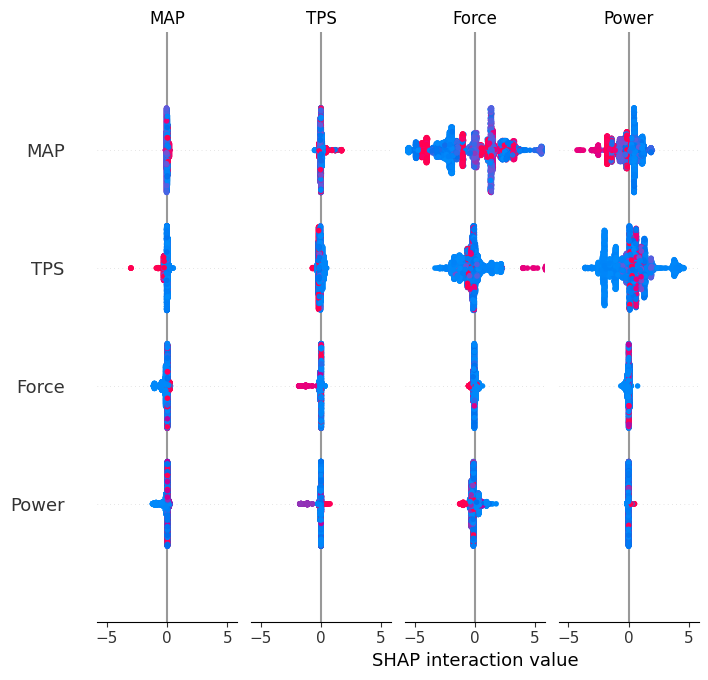

In [4]:
explainer = shap.TreeExplainer(new_xgb_model)
shap_values = explainer.shap_values(X_test)


feature_names = X.columns.tolist()



Generating SHAP summary plot for Class 1...


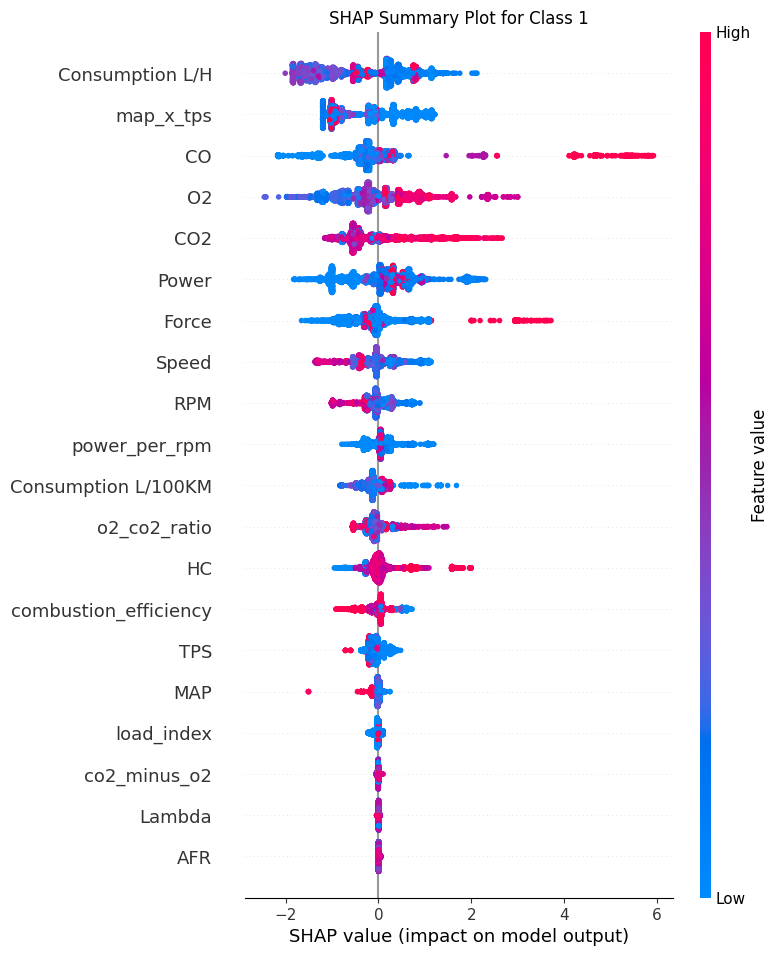


Generating SHAP summary plot for Class 2...


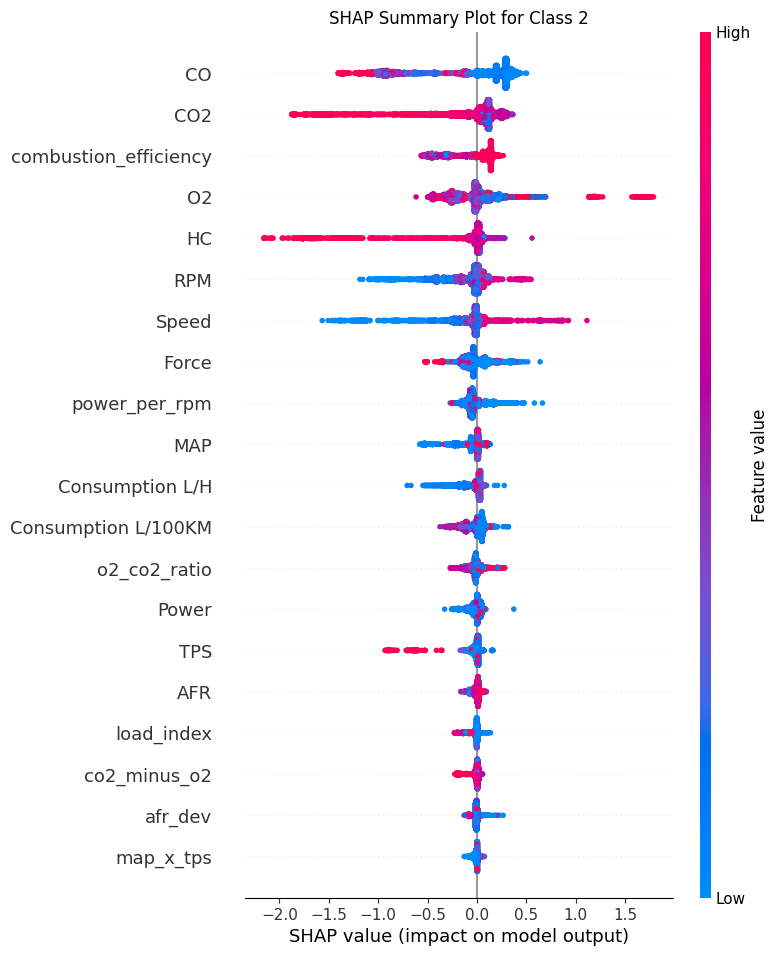


Generating SHAP summary plot for Class 3...


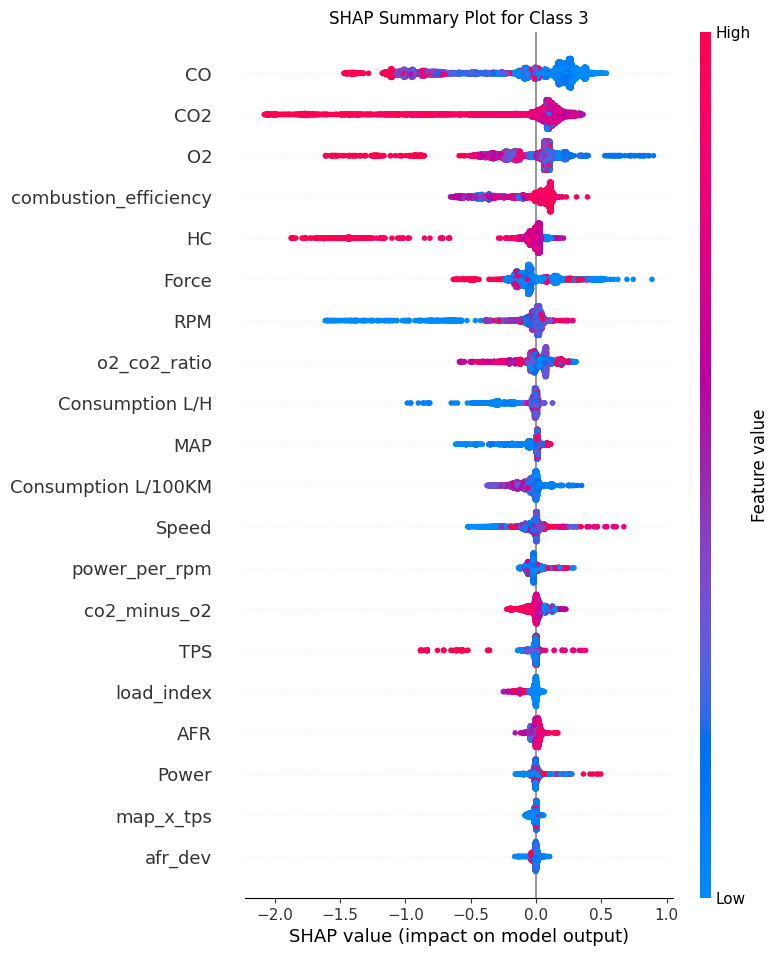

In [6]:
import matplotlib.pyplot as plt

class_labels = y.unique()

for i in range(1, 4):
    if i < shap_values.shape[2]:
        print(f"\nGenerating SHAP summary plot for Class {class_labels[i]}...")
        shap.summary_plot(shap_values[:, :, i], X_test, feature_names=feature_names, show=False)
        plt.title(f'SHAP Summary Plot for Class {class_labels[i]}')
        plt.show()
    else:
        print(f"Warning: No SHAP values available for class index {i}")
